<a href="https://colab.research.google.com/github/miya498/pytorch_basic/blob/main/program/th06_%E5%A4%9A%E5%80%A4%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7章　多値分類

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

## 7.8 データ準備

In [2]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


### データ絞り込み

In [3]:
# データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


### 訓練データ・検証データの分割

In [4]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


### 訓練データの散布図表示

In [5]:
# データを正解値ごとに分割

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

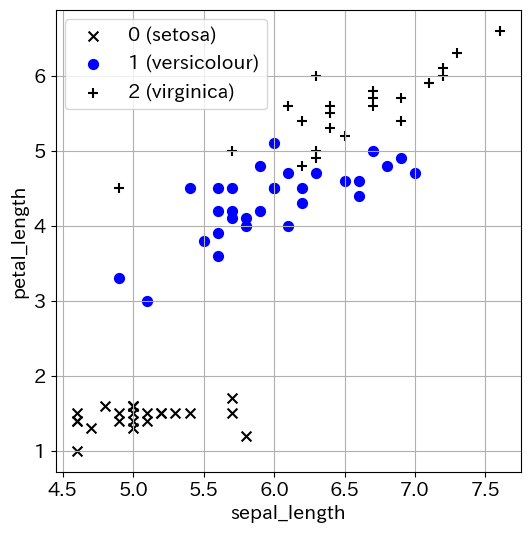

In [6]:
# 散布図の表示

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

## 7.9 モデル定義

In [7]:
# 学習用パラメータ設定

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
# 分類先クラス数　今回は3になる
n_output = len(list(set(y_train)))

# 結果確認
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [8]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)

        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1

# インスタンスの生成
net = Net(n_input, n_output)

### モデル確認

In [9]:
# モデル内のパラメータの確認
# l1.weightが行列にl1.biasがベクトルになっている

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [10]:
# モデルの概要表示

print(net)

# モデルのサマリー表示

summary(net, (2,))

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 最適化アルゴリズムと損失関数

In [11]:
# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

## 7.10 勾配降下法

### データのテンソル化

In [12]:
# 入力変数x_trainと正解値 y_trainのテンソル変数化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のテンソル変数化

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

### 計算グラフの可視化

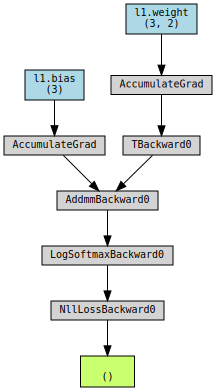

In [13]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 予測ラベル値の取得方法

In [14]:
# torch.max関数呼び出し
# 2つめの引数は軸を意味している。1だと行ごとの集計。
print(torch.max(outputs, 1))

torch.return_types.max(
values=tensor([12.0000, 12.7000,  7.6000, 13.0000, 12.3000,  7.6000,  7.3000, 11.1000,
        12.1000, 13.3000,  8.0000,  7.0000, 10.3000,  7.6000, 11.7000, 13.3000,
         7.4000, 13.5000,  8.2000,  8.4000, 12.7000,  6.6000,  7.9000, 12.2000,
        14.6000, 12.0000, 10.2000, 10.5000,  7.1000,  7.3000, 12.6000, 12.7000,
         7.4000,  7.7000, 10.8000, 11.5000, 11.5000, 14.0000, 12.8000, 10.8000,
        10.8000, 15.2000,  7.5000,  7.8000, 11.1000, 13.6000, 12.9000, 14.2000,
        12.7000,  7.6000, 10.9000,  7.0000, 10.9000, 11.2000,  7.4000, 11.7000,
        13.3000, 11.5000, 13.4000, 12.7000,  7.7000, 11.8000,  7.0000, 12.6000,
        11.7000, 10.9000,  9.2000, 12.2000, 10.4000, 12.1000,  7.5000,  9.1000,
        11.1000, 12.0000, 14.3000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [15]:
# ラベル値の配列を取得
torch.max(outputs, 1)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

### 繰り返し計算

In [16]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [17]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):

    # 訓練フェーズ

    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 予測ラベル算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ((epoch) % 20 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347, val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351, val_acc: 0.26667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098, val_acc: 0.56000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545, val_acc: 0.61333
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594, val_acc: 0.62667
Epoch [120/10000], loss: 0.79500 acc: 0.72000 val_loss: 0.80153, val_acc: 0.62667
Epoch [140/10000], loss: 0.76741 acc: 0.74667 val_loss: 0.77142, val_acc: 0.64000
Epoch [160/10000], loss: 0.74303 acc: 0.74667 val_loss: 0.74494, val_acc: 0.68000
Epoch [180/10000], loss: 0.72138 acc: 0.77333 val_loss: 0.72151, val_acc: 0.76000
Epoch [200/10000], loss: 0.70205 acc: 0.82667 val_loss: 0.70067, val_acc: 0.78667
Epoch [220/10000], loss: 0.68470 acc: 0.84000 val_loss: 0.68202, val_acc: 0.80000
Epoch [240/10000], los

## 7.11 結果確認

In [18]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.09263 精度: 0.26667
最終状態: 損失: 0.19802 精度: 0.96000


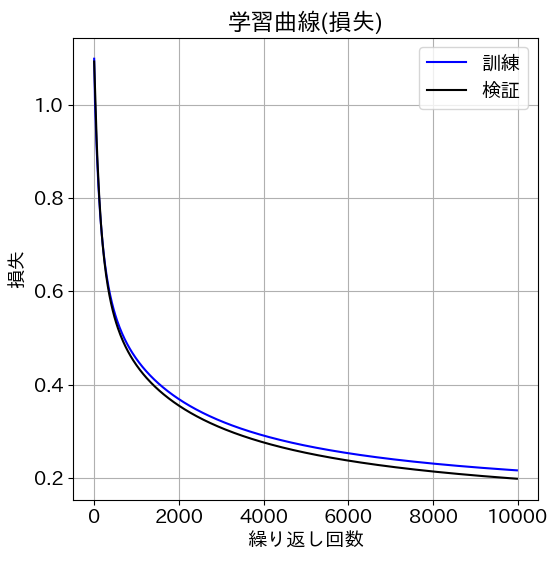

In [19]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

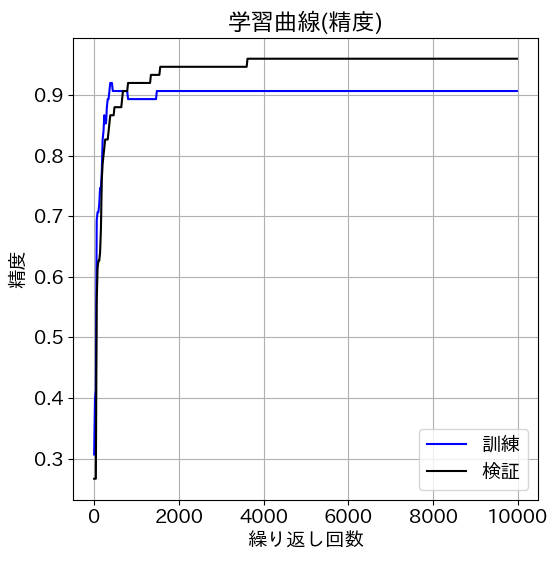

In [20]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### モデルへの入力と出力の確認

In [21]:
# 正解データの0番目、2番目、3番目

print(labels[[0,2,3]])

tensor([1, 0, 2])


In [22]:
# 該当する入力値を抽出

i3 = inputs[[0,2,3],:]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [23]:
# 出力値にsoftmax関数をかけた結果を取得

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[ 8.8071 14.1937 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


### 最終的な重み行列とバイアスの値

In [24]:
# 重み行列
print(net.l1.weight.data)

# バイアス
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


## 7.12 入力変数の4次元化

In [25]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 入力次元数
n_input = x_train.shape[1]

(75, 4) (75, 4) (75,) (75,)


In [26]:
print('入力データ(x)')
print(x_train[:5,:])
print(f'入力次元数: {n_input}')

入力データ(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
入力次元数: 4


In [27]:
# 入力データ x_train と正解データ y_train のテンソル変数化
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用データのテンソル変数化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [28]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [29]:
for epoch in range(num_epochs):

    # 訓練フェーズ

    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [30]:
# 損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.09158 精度: 0.26667
最終状態: 損失: 0.13724 精度: 0.96000


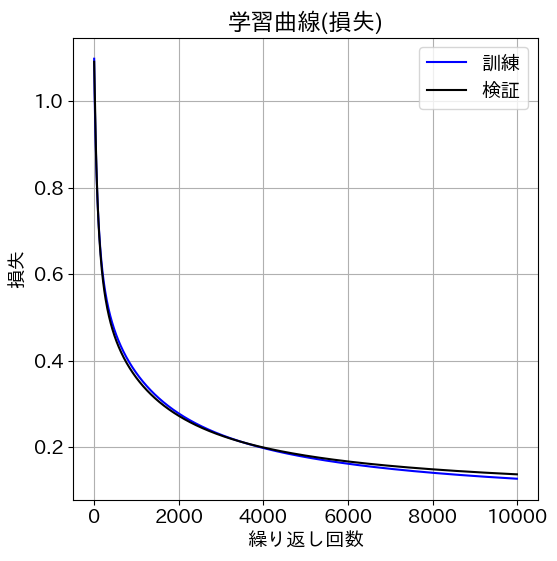

In [31]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

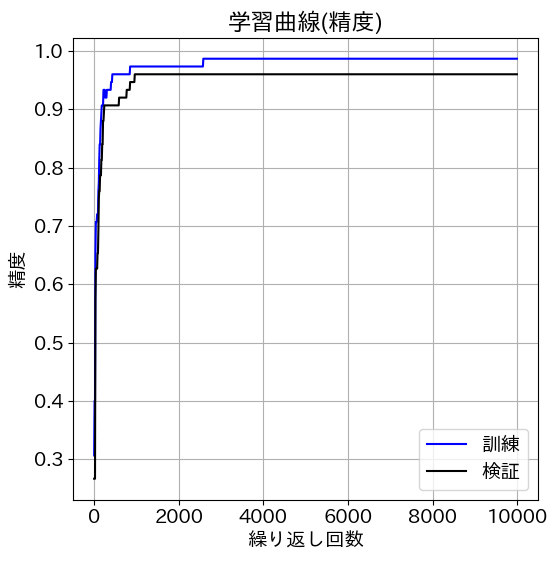

In [32]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()